In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import SumOfTiledHyperCubeBasisFcns
from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Define a helper function

In [3]:
def produce_y_image(f, x_range = [0.0, .999], y_range = [0.0, .999], n_points_per_side=100):
    
    with torch.no_grad():
        grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
                        y_range[0]:y_range[1]:n_points_per_side * 1j]

        grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
        grid_vec = torch.from_numpy(grid_vec.astype('float32'))

        y = f(grid_vec).detach().numpy()
        y_image = np.reshape(y, [n_points_per_side, n_points_per_side])
    
        return y_image
    
        #plt.imshow(y_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
        #plt.colorbar()

## Create a target mapping we will try to learn and training data

In [4]:
def true_map(x, bump_ctrs, bump_mags, bump_stds):
    
    n_smps = x.shape[0]
    
    with torch.no_grad():
        y = torch.zeros([n_smps,1])
        
        
        for i in range(n_bumps):
            bump_ctr = bump_ctrs[i, :]
            bump_mag = bump_mags[i]
            bump_std = bump_stds[i, :]
    
            y_i = bump_mag*torch.exp(-1*torch.sum(((x - bump_ctr)/bump_std)**2,1))
            y += y_i.view([n_smps, 1])
            
        return y

In [5]:
n_bumps = 20

bump_ctrs = torch.zeros(n_bumps, 2)
bump_mags = torch.ones(n_bumps)
bump_stds = .05*torch.ones(n_bumps, 2)

for i in range(n_bumps):
    bump_ctrs[i,:] = torch.rand(2)

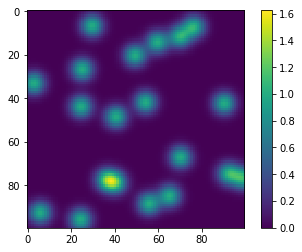

In [6]:
# Visualize target mapping
f_true = lambda x: true_map(x, bump_ctrs, bump_mags, bump_stds)
true_y = produce_y_image(f_true)
plt.imshow(true_y)
plt.colorbar()

## Define the function we will fit

In [26]:
n_divs_per_dim = [500, 500]
dim_ranges = np.asarray([[0, 1.0], [0, 1.0]])
n_div_per_bump_per_dim = np.asarray([5, 5], dtype='int')

f = SumOfTiledHyperCubeBasisFcns(n_divs_per_dim, dim_ranges, n_div_per_bump_per_dim)

## Generate sample points for training

In [27]:
n_smps = 100000
x = torch.rand([n_smps, 2])
y = f_true(x)

## Fit the function 

In [28]:
optimizer = torch.optim.Adam(f.parameters(), lr=.0001)

for i in range(100):
    
    optimizer.zero_grad()
    er = torch.sum((y - f(x))**2)
    er.backward()
    optimizer.step()
    
    er_r = er.detach().numpy()
    
    if i % 10 == 0:
        print('er: ' + str(er))
    

er: tensor(8800.6797, grad_fn=<SumBackward0>)
er: tensor(8092.4512, grad_fn=<SumBackward0>)
er: tensor(7449.5845, grad_fn=<SumBackward0>)
er: tensor(6864.0898, grad_fn=<SumBackward0>)
er: tensor(6329.9033, grad_fn=<SumBackward0>)
er: tensor(5841.5015, grad_fn=<SumBackward0>)
er: tensor(5393.9619, grad_fn=<SumBackward0>)
er: tensor(4982.9785, grad_fn=<SumBackward0>)
er: tensor(4604.8506, grad_fn=<SumBackward0>)
er: tensor(4256.4204, grad_fn=<SumBackward0>)


## Visualize true and target mapping

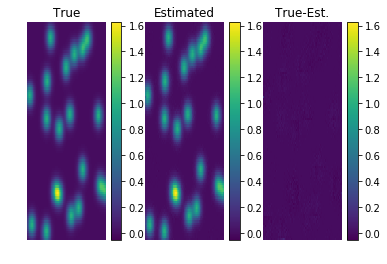

In [25]:
est_y = produce_y_image(f)
axes = cmp_n_mats([true_y, est_y, true_y-est_y], 
           titles=['True', 'Estimated', 'True-Est.'],
           show_colorbars=True)